In [1]:
# Import libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', -1)
import scipy

In our analysis variables related to the QS Top Universities ranking are denoted with the letters QS. 

Variables related to Times Higher Education ranking are denoted with the letters THE.

# QS Data

The QS World University ranking webpage (link: https://www.topuniversities.com/qs-world-university-rankings/methodology) states that the overall ranking is made up of the following parameters and weights:
1. Academic Reputation - 40 %
2. Employer Reputation - 10 %
3. Faculty/Student Ratio - 20 %
4. Citations per faculty - 20 %
5. International Faculty Ratio - 5 %
6. International Student Ratio - 5 %

### Scraping the data and building the data frame

Using postman we are able to identify the URL that we need to scrape. The JSON that we obtain contains a list of dictionaries containing the information on the universities. We extract that list (QS_list) and use it to build the data frame. We only keep the top 200 rows. Since there is no data on faculty and students at NYU (row 51) we analyse the QS data without NYU and drop this row from our data frame.

In [2]:
QS_URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508416844720'
reqQS = requests.get(QS_URL)
# reqQS.json() is a dict object made of 1 entry 'data' : LIST of dicts
QS_list = reqQS.json()['data']
# Building the data frame from QS_list
QS_data = pd.DataFrame(QS_list)
QS_data = QS_data[:200]
QS_data[['Name','QS_Rank','Country','Region','url']] = QS_data[['title','rank_display','country','region','url']]
QS_data = QS_data[['Name','QS_Rank','Country','Region','url']]
QS_data_with_NYU = QS_data 
# There is no statistical data for NYU (row 51). We drop row 51
QS_data = QS_data.drop([51]) 

We run through the data frame row by row and use BeautifulSoup to scrape the information on faculty and student numbers at each university from the url that links to the institution details on QS rankings. The relevant information is stored and then added to our data frame.

In [3]:
fac_staff = [0] * 199
fac_staff_int = [0] * 199
students = [0] * 199
students_int = [0] * 199

i = 0
for link in QS_data.url:
    r = requests.get('https://www.topuniversities.com' + link + '#wurs')
    soup = BeautifulSoup(r.text, 'html.parser')
    all_h3 = soup.find_all('div', class_= "number")
    fac_staff[i] = int(all_h3[0].text[1:-1].replace(',', ''))
    fac_staff_int[i] = int(all_h3[1].text[1:-1].replace(',', ''))
    students[i] = int(all_h3[2].text[1:-1].replace(',', ''))
    students_int[i] = int(all_h3[3].text[1:-1].replace(',', ''))
    i = i + 1

QS_data['fac_staff'] = fac_staff
QS_data['fac_staffint'] = fac_staff_int
QS_data['students'] = students
QS_data['students_int'] = students_int

We observe that for the Indian Institute of Science (IISc) Bangalore (position 189) there is no number for international staff in the data and hence the numbers for students and students_int in our data frame have been shifted left in the table. We correct this manually.

In [4]:
QS_data.loc[189, 'fac_staffint']=0
QS_data.loc[189, 'students']=4071
QS_data.loc[189, 'students_int']=47
#QS_data[188:189]

### Analysis of (a) the ratio between faculty members and students, (b) the ratio of international students



For each university we calculate the required ratios. 

In [5]:
QS_data['stats_student_staff_ratio'] = QS_data.students / QS_data.fac_staff
QS_data['stats_pc_intl_students'] = 100 * QS_data.students_int / QS_data.students
QS_data['stats_student_staff_ratio'].head()

0    3.711268
1    3.705484
2    5.156092
3    2.366212
4    3.418944
Name: stats_student_staff_ratio, dtype: float64

Above we chose the student/staff ratio (rather than the staff/student ratio) because 1) this ratio is used by THE ranking and so comparison between rankings becomes easier; and 2) this ratio returns values larger than 1 which is more illustrative for differences than its inverse.

For each ratio we proceed as follows:
1) We sort the data frame;
2) Plot the Top 10 universities in this new ranking;
3) Aggregate the ranking by country and provide a bar plot;
4) Aggregate the ranking by region and provide a bar plot.

There are various ways in which one can aggregate the data. For example for each country/region one may calculate the total number of staff and students before forming the ratio. However if we have one very large university with a particularly high/low ratio then its contribution would be weighted more stongly than that of smaller universities. 

Instead our aim is to treat all universities in a country/region on equal footing. Hence we calculate the average of their ratios. That way the good/bad performance of a small university matters equally to the score of a large institution. We are aware that this approach has its own disadvantages but feel that it provides reasonable insight. (In the mean time it has been confirmed on Mattermost that we should use averages for the aggragates.)

#### Ratio between faculty members and students - overall

In [6]:
QS_sorted_v1 = QS_data.sort_values('stats_student_staff_ratio')
QS_sort_ratio_a = QS_sorted_v1[['Name','Region','stats_student_staff_ratio']]
QS_ratio_a_top10 = QS_sort_ratio_a.head(10)
#QS_ratio_a_top20 = QS_sort_ratio_a.head(20)

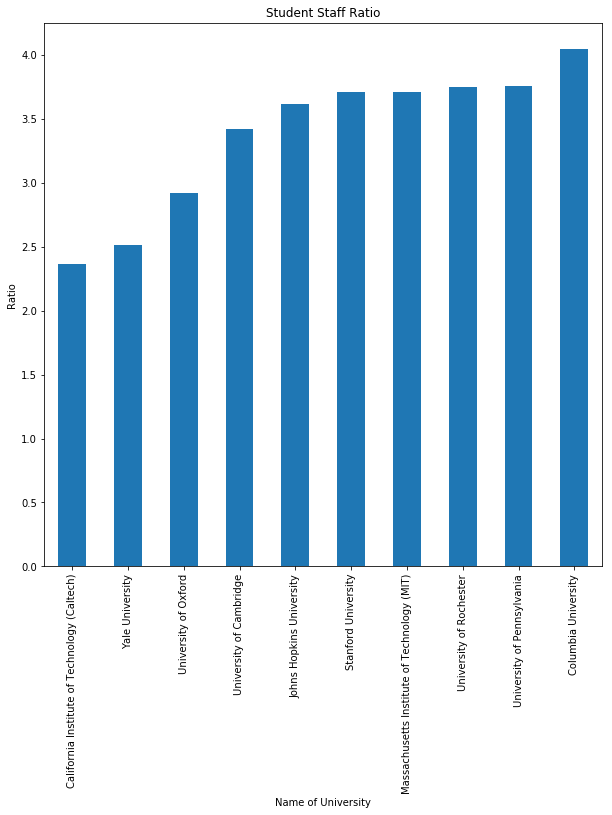

In [7]:
QS_ratio_a_top10_nameind = QS_ratio_a_top10.copy()
QS_ratio_a_top10_nameind.index = QS_ratio_a_top10.Name
#QS_ratio_a_top10_nameind

QS_ratio_a_top10_nameind.stats_student_staff_ratio.plot(kind='bar',title='Student Staff Ratio',figsize=(10,10))
plt.ylabel('Ratio')
plt.xlabel('Name of University')
plt.show()

A look at the original rankings of these Top 10 reveals that, with the notable exception of the University of Rochester, all universities are placed in the top 20 of the original ranking.

In [8]:
QS_ratio_a_top10

,Name,Region,stats_student_staff_ratio
3,California Institute of Technology (Caltech),North America,2.366212
15,Yale University,North America,2.510526
5,University of Oxford,Europe,2.921481
4,University of Cambridge,Europe,3.418944
16,Johns Hopkins University,North America,3.618557
1,Stanford University,North America,3.705484
0,Massachusetts Institute of Technology (MIT),North America,3.711268
185,University of Rochester,North America,3.750876
18,University of Pennsylvania,North America,3.753228
17,Columbia University,North America,4.046696


This result could suggest that the QS_Rank is correlated with a low student/staff ratio. 

However, for QS this ratio only makes up 20% of the overall ranking. A more likely explanation comes from the fact that research quality (affecting academic reputation) and output (measured in citations) are both important factor for the ranking. Therefore research focused universities who have a high number of research-only staff will produce both high quality research as well as a lower the student/staff ratio.

We note that with the exception of Oxford and Cambridge, the top 10 universities for this metric are North American. However a look the top 20 reveals that the trend does not continue.

#### Ratio between faculty members and students - Countries

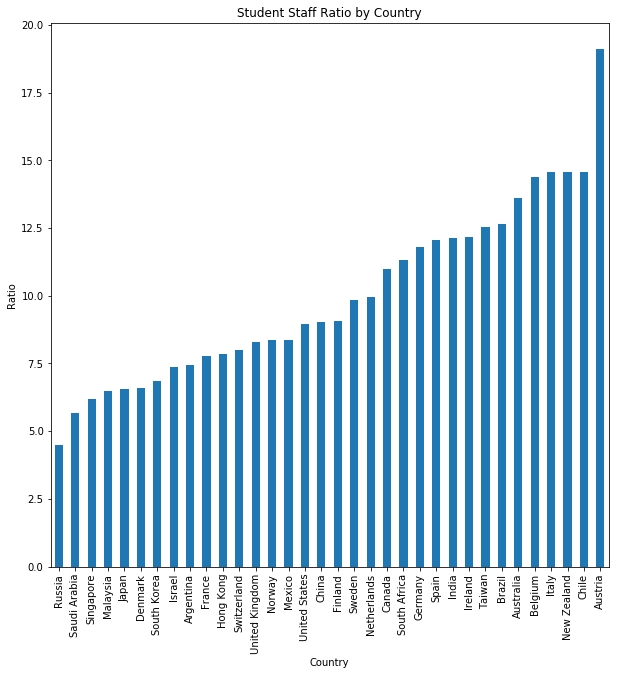

In [9]:
QS_countries = QS_data.groupby(['Country']).mean()
QS_countries_sort_ratio_a = QS_countries.sort_values('stats_student_staff_ratio', ascending=True)
#(QS_countries_sort_ratio_a['stats_student_staff_ratio']).plot.bar()

QS_countries_sort_ratio_a.stats_student_staff_ratio.plot(kind='bar',title='Student Staff Ratio by Country',figsize=(10,10))
plt.ylabel('Ratio')
plt.xlabel('Country')
plt.show()

#### Ratio between faculty members and students - Regions

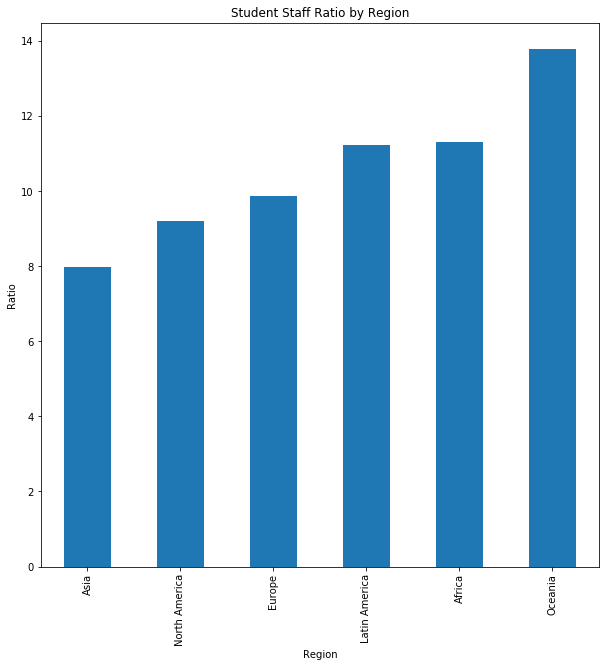

In [10]:
QS_region = QS_data.groupby(['Region']).mean()
QS_region_sort_ratio_a = QS_region.sort_values('stats_student_staff_ratio', ascending=True)
#(QS_region_sort_ratio_a['stats_student_staff_ratio']).plot.bar()

QS_region_sort_ratio_a.stats_student_staff_ratio.plot(kind='bar',title='Student Staff Ratio by Region',figsize=(10,10))
plt.ylabel('Ratio')
plt.xlabel('Region')
plt.show()

The regional data has to be interpreted with great care. 
We know from our previous analysis that 8 out of the top 10 universities for this ratio where North American. Yet this is not reflected in the regional data. The reason is that the QS-ranking has 53 university in North America (list below). The remaining 45 universities clearly lower the average for this region.

In [11]:
QS_region_count = QS_data.groupby(['Region']).count()
print(QS_region_count.Name)

Region
Africa           1 
Asia             38
Europe           89
Latin America    7 
North America    53
Oceania          11
Name: Name, dtype: int64


This list shows that those regions with a high number of universities perform worth under the averaging. In contrast the 3 'best' regions have 11, 1 respectively 7 universities in the top 200 (South Africa is the only African country represented). 

We observed earlier that research strength affects the ranking significantly. We hypothesis that within each region the top universities in the QS-ranking are likely more research focused and hence typically have a better student/staff ratio score. If we only compared the top 5 or 10 from each region then North America should come out on top again. We will aim to pick this up later on.

#### Ratio of international students - overall

In [12]:
QS_sorted_v2 = QS_data.sort_values('stats_pc_intl_students', ascending=False)
QS_sort_ratio_b = QS_sorted_v2[['Name','Region','stats_pc_intl_students']]
QS_ratio_b_top10 = QS_sort_ratio_b.head(10)
QS_ratio_b_top20 = QS_sort_ratio_b.head(20)
QS_ratio_b_top10


,Name,Region,stats_pc_intl_students
34,London School of Economics and Political Science (LSE),Europe,69.139344
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),Europe,57.004738
7,Imperial College London,Europe,54.356743
198,Maastricht University,Europe,50.253280
47,Carnegie Mellon University,North America,47.806229
6,UCL (University College London),Europe,47.792793
91,University of St Andrews,Europe,45.795455
41,The University of Melbourne,Oceania,42.743350
126,Queen Mary University of London,Europe,42.181593
25,The University of Hong Kong,Asia,40.714356


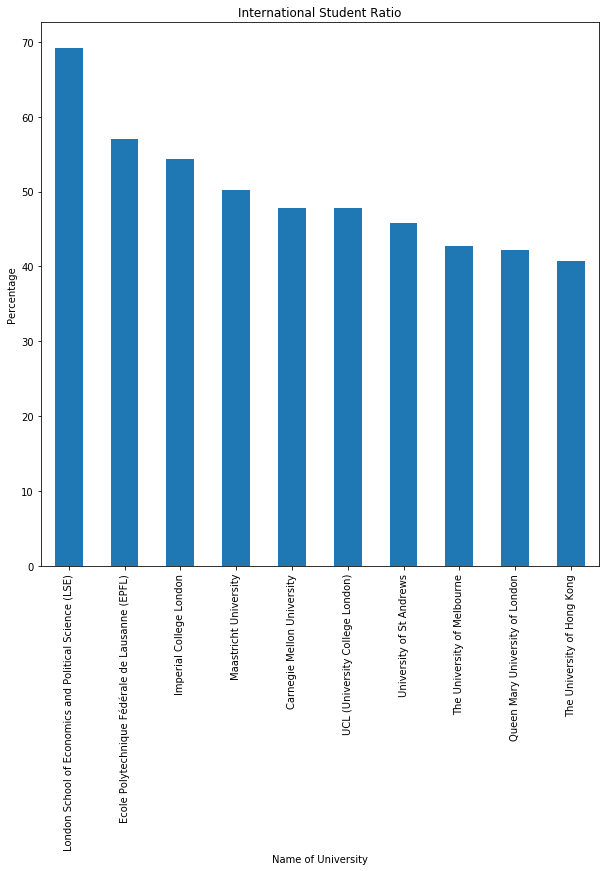

In [13]:
QS_ratio_b_top10.index = QS_ratio_b_top10.Name 
QS_ratio_b_top10.stats_pc_intl_students.plot(kind='bar',title='International Student Ratio',figsize=(10,10))
plt.ylabel('Percentage')
plt.xlabel('Name of University')
plt.show()

Unlike the student/staff ratio, there does not appear to be a link between the international student ratio and the ranking. 

We observe that the European universities fair stronger for this metric, while North America performs 'poorly'. This might be related to the facts that 1) EU-citizens can study in other EU-countries as home students (reduced fees) and 2) the high fees for American universities. 

#### Ratio of international students  - Countries

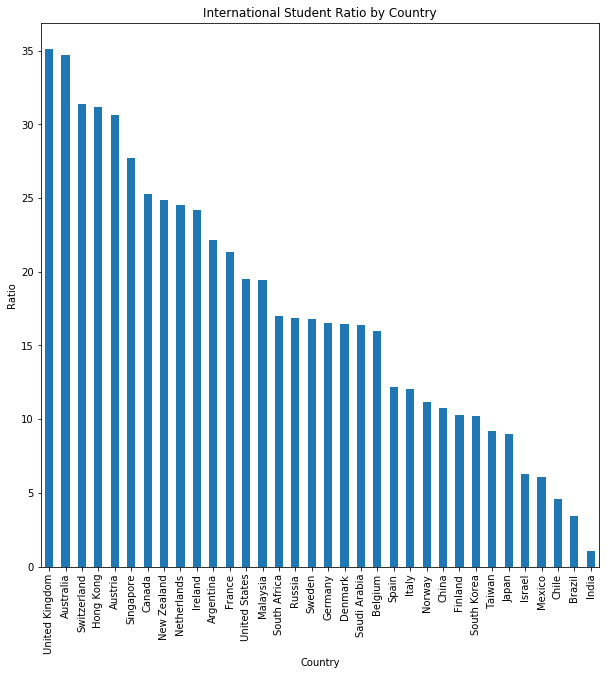

In [14]:
QS_countries_sort_ratio_b = QS_countries.sort_values('stats_pc_intl_students', ascending=False)
#(QS_countries_sort_ratio_b['stats_pc_intl_students']).plot.bar()

QS_countries_sort_ratio_b.stats_pc_intl_students.plot(kind='bar',title='International Student Ratio by Country',figsize=(10,10))
plt.ylabel('Ratio')
plt.xlabel('Country')
plt.show()

#### Ratio of  international students  - Regions

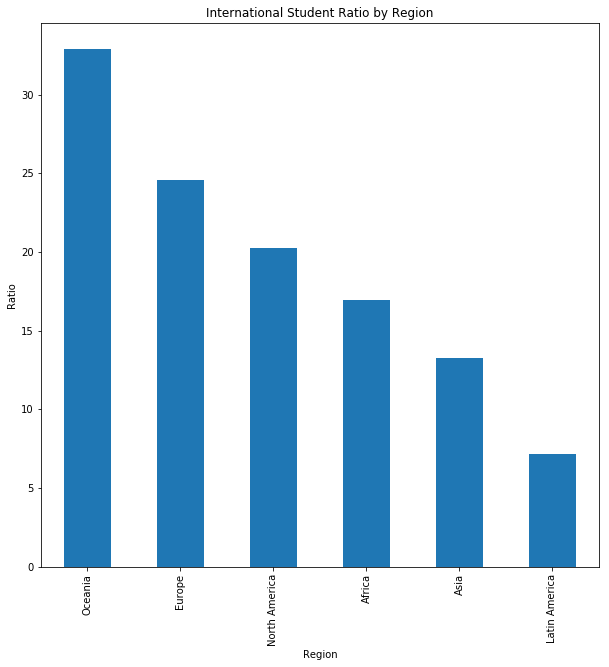

In [15]:
QS_region_sort_ratio_b = QS_region.sort_values('stats_pc_intl_students', ascending=False)
#(QS_region_sort_ratio_a['stats_pc_intl_students']).plot.bar()

QS_region_sort_ratio_b.stats_pc_intl_students.plot(kind='bar',title='International Student Ratio by Region',figsize=(10,10))
plt.ylabel('Ratio')
plt.xlabel('Region')
plt.show()

The top 5 countries are: UK, Australia, Switzerland, Hongkong and Austria.

In terms of the regions the comments regarding small numbers for Oceania, Africa and Latin America still holds.

For our subsequent work we use the index of our data frame to define the unique rank. Thus we do not have to worry about ties and we also get a numerical value.

In [16]:
QS_data['QS_Rank_unique'] = (QS_data.index + 1)
# Save QS_data for quicker access
QS_data.to_csv('QS_data.csv')

## THE data

THE ranking Criteria and weighting (According to wikipedia: https://en.wikipedia.org/wiki/Times_Higher_Education_World_University_Rankings#Criteria_and_weighting) :
1. Industry Income and innovation - 2.5 %
2. Ratio of international to domestic staff - 3 %
2. Ratio of international to domestic students - 2 %
3. Reputational survey (teaching) - 15 %
4. Teaching – the learning environment - 15 %
5. Research – volume, income and reputation - 30 % where Reputational survey (research) is 19.5 %
6. Citations – research influence - 32.5 % 

### Scraping the data and building the data frame

For THE data the two ratios are already given in the data. However the data is given as strings and needs to be converted into numeric form.

THE data does not include the region. We use the QS data to create a country/region dictionary, and manually add the cases that are new for THE data (Luxemburg and the Russian Federation).

In [17]:
THE_URL = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
reqTHE = requests.get(THE_URL)
# Note reqQS.json() is a dict object made of 1 entry 'data' : LIST of dicts
THE_list = reqTHE.json()['data']
# Transform the list into a data frame
THE_data = pd.DataFrame(THE_list)
THE_data = THE_data[:200]
THE_data[['Name','THE_Rank','Country','url','stats_student_staff_ratio','stats_pc_intl_students']] = THE_data[['name','rank','location','url','stats_student_staff_ratio','stats_pc_intl_students']]
THE_data = THE_data[['Name','THE_Rank','Country','url','stats_student_staff_ratio','stats_pc_intl_students']]

#Converting the THE ratios to numeric format
THE_data['stats_student_staff_ratio'] = pd.to_numeric(THE_data['stats_student_staff_ratio'])

THE_data['stats_pc_intl_students']  = THE_data['stats_pc_intl_students'].str.replace(r'%$', '')
THE_data['stats_pc_intl_students'] = pd.to_numeric(THE_data['stats_pc_intl_students'])

# Add region to THE ranking
THE_data['Region'] = 'unkown'
region_dict = QS_data[['Country', 'Region']].set_index('Country').to_dict()['Region']
region_dict['Luxembourg'] = 'Europe'
region_dict['Russian Federation'] = 'Asia'

for i in range(0,200):
    THE_data.loc[i, 'Region'] = region_dict[THE_data.loc[i, 'Country']]

#THE_data.head()

### Analysis of (a) the ratio between faculty members and students, (b) the ratio of international students

We proceed as for QS data. For each ratio:
1) We sort the data frame;
2) Plot the Top 10 universities in this new ranking;
3) Aggregate the ranking by country and provide a bar plot;
4) Aggregate the ranking by region and provide a bar plot.

#### Ratio between faculty members and students - overall

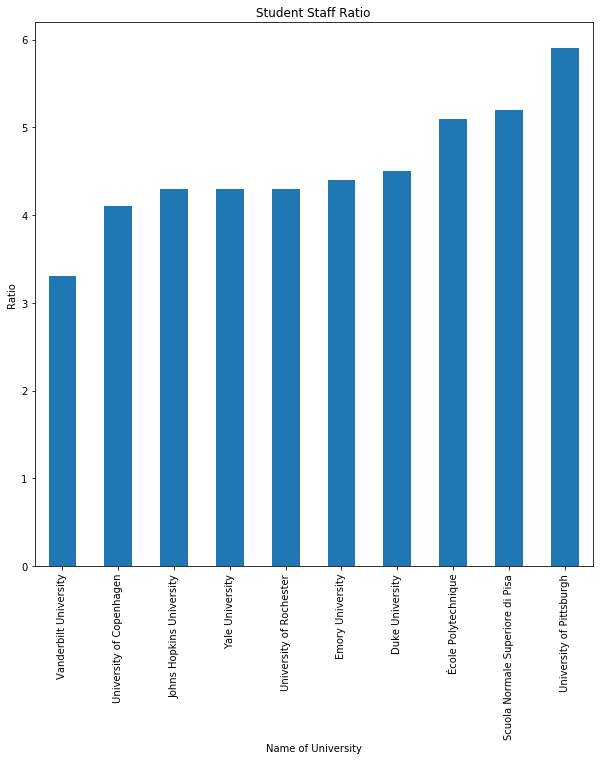

In [18]:
THE_ratio_a_top10 = THE_data.sort_values('stats_student_staff_ratio').head(10)
THE_ratio_a_top10.index =  THE_ratio_a_top10.Name

THE_ratio_a_top10.stats_student_staff_ratio.plot(kind='bar',title='Student Staff Ratio',figsize=(10,10))
plt.ylabel('Ratio')
plt.xlabel('Name of University')
plt.show()

While the staff/student ratio accounted for 20 % of the QS-ranking score, it does not directly influence the THE-score directly and related metrics, like international student ratio or international staff ratio, are weighted very lightly for the THE-ranking. Thus we do not expect to see any correlation between the student/staff ratio and the THE-ranking. A look at the placement of the top 10 for this ratio confirms this.

In [19]:
THE_ratio_a_top10

,Name,THE_Rank,Country,url,stats_student_staff_ratio,stats_pc_intl_students,Region
Name,,,,,,,
Vanderbilt University,Vanderbilt University,=105,United States,/world-university-rankings/vanderbilt-university,3.3,13,North America
University of Copenhagen,University of Copenhagen,=109,Denmark,/world-university-rankings/university-copenhagen,4.1,14,Europe
Johns Hopkins University,Johns Hopkins University,13,United States,/world-university-rankings/johns-hopkins-university,4.3,24,North America
Yale University,Yale University,12,United States,/world-university-rankings/yale-university,4.3,21,North America
University of Rochester,University of Rochester,=153,United States,/world-university-rankings/university-rochester,4.3,29,North America
Emory University,Emory University,98,United States,/world-university-rankings/emory-university,4.4,19,North America
Duke University,Duke University,17,United States,/world-university-rankings/duke-university,4.5,22,North America
École Polytechnique,École Polytechnique,115,France,/world-university-rankings/ecole-polytechnique,5.1,36,Europe
Scuola Normale Superiore di Pisa,Scuola Normale Superiore di Pisa,184,Italy,/world-university-rankings/scuola-normale-superiore-di-pisa,5.2,7,Europe


We observe that the values for this ratio varies between the two data sets. The difference may stem from the fact QS counts faculty members and while THE counts staff members. The latter allows for a wider scope as it may for exmaple count teaching assistants and lab technicians.

#### Ratio between faculty members and students - Countries

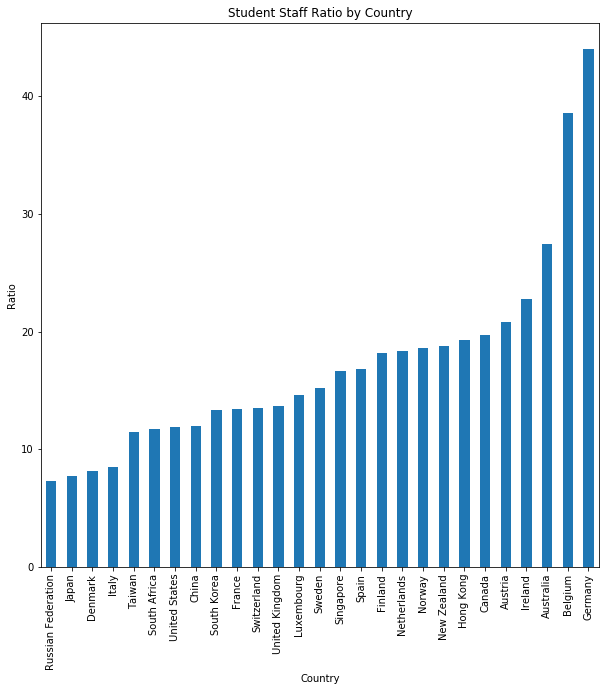

In [20]:
THE_countries = THE_data.groupby(['Country']).mean()
THE_countries_sort_ratio_a = THE_countries.sort_values('stats_student_staff_ratio', ascending=True)
#(THE_countries_sort_ratio_a['stats_student_staff_ratio']).plot.bar()

THE_countries_sort_ratio_a.stats_student_staff_ratio.plot(kind='bar',title='Student Staff Ratio by Country',figsize=(10,10))
plt.ylabel('Ratio')
plt.xlabel('Country')
plt.show()

#### Ratio between faculty members and students - Regions

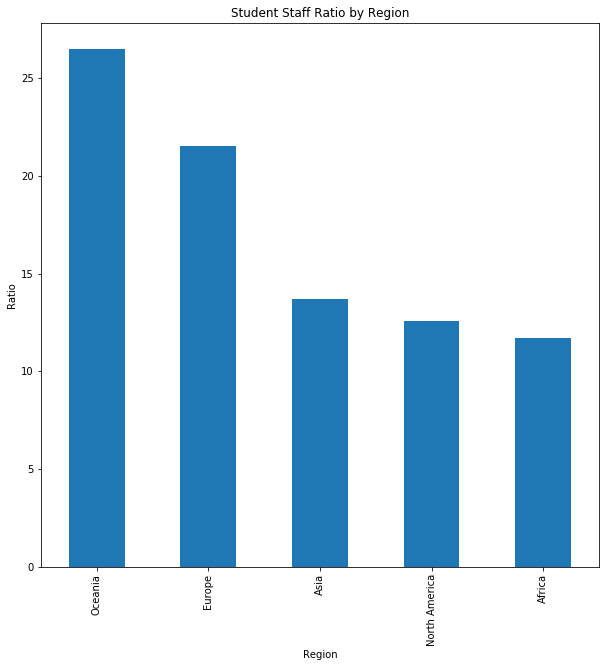

In [21]:
THE_region = THE_data.groupby(['Region']).mean()
THE_region_sort_ratio_a = THE_region.sort_values('stats_student_staff_ratio', ascending=False)
#(THE_countries_sort_ratio_a['stats_student_staff_ratio']).plot.bar()

THE_region_sort_ratio_a.stats_student_staff_ratio.plot(kind='bar',title='Student Staff Ratio by Region',figsize=(10,10))
plt.ylabel('Ratio')
plt.xlabel('Region')
plt.show()

In [22]:
THE_region_count = THE_data.groupby(['Region']).count()
#print(THE_region_count.Name)

As before regional data has to be interpreted with a lot of care. In fact we observe that none of the 7 Latin American universities from the QS ranking made it into the THE ranking.

#### Ratio of international students - overall

In [23]:
THE_ratio_b_top10 = THE_data.sort_values(by='stats_pc_intl_students',ascending=False).head(10)
THE_ratio_b_top10.index =  THE_ratio_b_top10.Name
THE_ratio_b_top10[['Name','Region','stats_pc_intl_students']]

,Name,Region,stats_pc_intl_students
Name,,,
London School of Economics and Political Science,London School of Economics and Political Science,Europe,71
University of Luxembourg,University of Luxembourg,Europe,57
École Polytechnique Fédérale de Lausanne,École Polytechnique Fédérale de Lausanne,Europe,55
Imperial College London,Imperial College London,Europe,55
Maastricht University,Maastricht University,Europe,50
University College London,University College London,Europe,49
University of St Andrews,University of St Andrews,Europe,48
Carnegie Mellon University,Carnegie Mellon University,North America,45
Queen Mary University of London,Queen Mary University of London,Europe,45


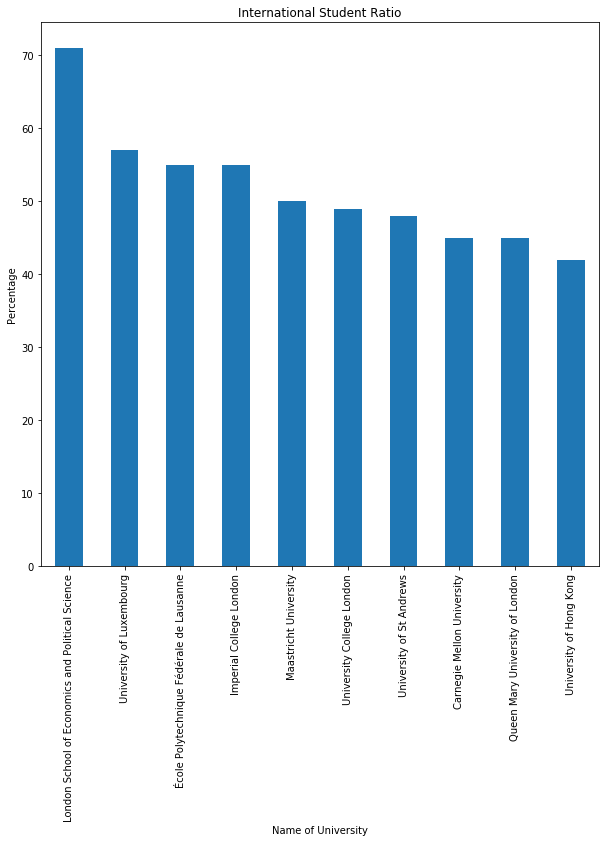

In [24]:
THE_ratio_b_top10.stats_pc_intl_students.plot(kind='bar',title='International Student Ratio',figsize=(10,10))
plt.ylabel('Percentage')
plt.xlabel('Name of University')
plt.show()

The numbers agree roughly with those of the QS ranking. Luxemburg has made it into THE top 200 ranking, while Melbourne has not.

#### Ratio of international students - Countries

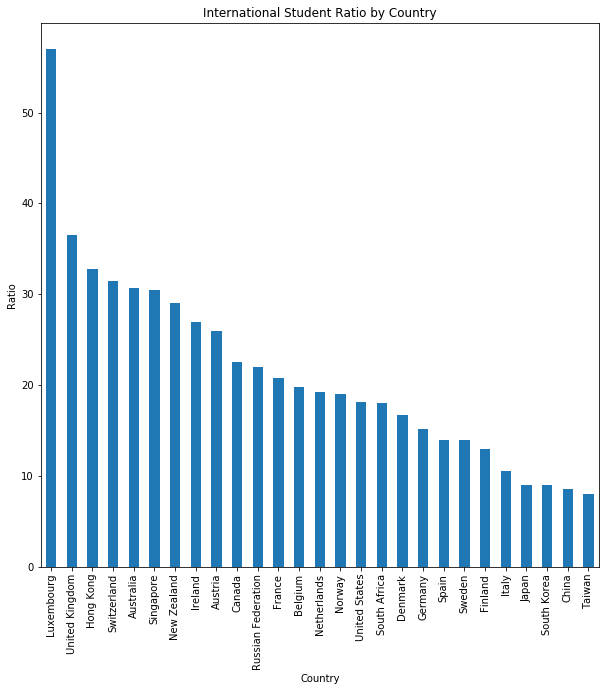

In [25]:
THE_countries_sort_ratio_b = THE_countries.sort_values('stats_pc_intl_students', ascending=False)
#(QS_countries_sort_ratio_b['stats_pc_intl_students']).plot.bar()

THE_countries_sort_ratio_b.stats_pc_intl_students.plot(kind='bar',title='International Student Ratio by Country',figsize=(10,10))
plt.ylabel('Ratio')
plt.xlabel('Country')
plt.show()

Luxemburg is an outlier. The population of Luxemburg is comparitevely, and thus so is number of home students. Luxemburg easily attracts students from neighbouring countries (Belgium, France and Germany)

#### Ratio of international students - Regions

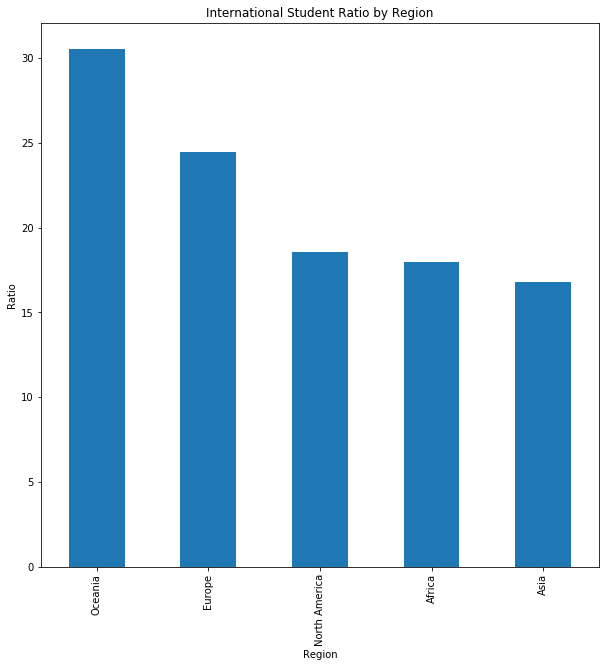

In [26]:
THE_region_sort_ratio_b = THE_region.sort_values('stats_pc_intl_students', ascending=False)
#(QS_countries_sort_ratio_b['stats_pc_intl_students']).plot.bar()

THE_region_sort_ratio_b.stats_pc_intl_students.plot(kind='bar',title='International Student Ratio by Region',figsize=(10,10))
plt.ylabel('Ratio')
plt.xlabel('Region')
plt.show()

Again we define the unique rank for later analysis.

In [27]:
THE_data['THE_Rank_unique'] = (THE_data.index + 1)

In [28]:
# Save THE_data for quicker access
THE_data.to_csv('THE_data.csv')

### Overall comments for Task 1 and Task 2

We briefly summarise some of the main comments made above. 

1) Looking at the top 10 universities for the student/staff ratio, it appears that htis ratio correlates with the QS-ranking but not with the THE-ranking. 
However we emphasized already that the underlying cause may be that research focused universities have strong academic reputations and citation counts, both of which form the bulk of the QS-ranking. Hence these universities perform better in the ranking as well as the student/staff ratio.

2) The regional data has to be interpreted with care since Asia, Europe and North America average over a large number of institutions, while Oceania, Africa and South America have very few institutions that break into the top 200. We conjecture that the top universities with in a region may have stronger research focus and hence a better student/staff ratio.

3) We observed that when comparing the values for either of the two ratios between the two ranking that there are a lot of inconsistencies. The most likely source is the use of faculty (QS) vs staff members (THE). The latter creates higher ratios.

We aim to analyse these points in more detail in Task 4. 

In [29]:
#THE_data

## Task 3 - Merging the data frames

To merge the cells we first define the function 'similar', which uses the class SequenceMatcher from difflib. SequenceMatcher aims to find the best match between sequences (for us strings) by looking for the longest connected subsequence that matches. It then repeats this procedure for the left over pieces as well. 
The function 'similar' returns a ratio (0-1) depending on how good the names of the universities fit together.

Afterwards we loop through every name of the QS Ranking and choose the one which has the highest similarity ratio. We add this university to the merged DataFrame. Then we have to delete those Uniiversities which are not listed in both rankings and therefore were wrongly matched. 

Remark: 'Vrije Universiteit Brussel' and 'Université libre de Bruxelles' are two distinct universities.

In [30]:
QS_data = QS_data.reset_index(drop=True)

Merged_data = QS_data[['Name', 'QS_Rank', 'QS_Rank_unique', 'Country', 'Region', 'fac_staff', 'fac_staffint', 'students', 'students_int', 'stats_student_staff_ratio', 'stats_pc_intl_students']]
Merged_data.columns = ['Name_QS', 'QS_Rank', 'QS_Rank_unique', 'Country', 'Region', 'fac_staff', 'fac_staffint', 'students', 'students_int', 'student_staff_ratio_QS', 'pc_intl_students_QS']

Merged_data['Name_THE'] = ''
Merged_data['THE_Rank'] = ''
Merged_data['THE_Rank_unique'] = ''
Merged_data['student_staff_ratio_THE'] = ''
Merged_data['pc_intl_students_THE'] = ''

n = 200
stats = [0] * len(QS_data.Name[:n])
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
j = 0
for r in QS_data.Name[:n]:
    k = 0
    for i in THE_data.Name:
        if similar(r,i) > k:
            Merged_data.loc[j, 'Name_THE'] = THE_data.loc[THE_data.loc[THE_data.Name == i].index, 'Name'].values[0]
            Merged_data.loc[j, 'THE_Rank'] = THE_data.loc[THE_data.loc[THE_data.Name == i].index, 'THE_Rank'].values[0]
            Merged_data.loc[j, 'THE_Rank_unique'] = THE_data.loc[THE_data.loc[THE_data.Name == i].index, 'THE_Rank_unique'].values[0]
            Merged_data.loc[j, 'student_staff_ratio_THE'] = THE_data.loc[THE_data.loc[THE_data.Name == i].index, 'stats_student_staff_ratio'].values[0]
            Merged_data.loc[j, 'pc_intl_students_THE'] = THE_data.loc[THE_data.loc[THE_data.Name == i].index, 'stats_pc_intl_students'].values[0]
            k = similar(r,i)
    j = j + 1
    
Merged_data = Merged_data.drop([42,54,61,64,66,73,74,88,104,112,114,119,120,121,122,126,131,136,143,149,150,153,154,158,160,162,166,168,170,171,174,175,177,180,181,183,185,186,187,188,192,196,198]) 

Merged_data['fac_international_ratio'] = Merged_data.fac_staffint / Merged_data.fac_staff

In [31]:
# Save Merged_data for quicker access
Merged_data.to_csv('Merged_data.csv')
Merged_data.head(10)

,Name_QS,QS_Rank,QS_Rank_unique,Country,Region,fac_staff,fac_staffint,students,students_int,student_staff_ratio_QS,pc_intl_students_QS,Name_THE,THE_Rank,THE_Rank_unique,student_staff_ratio_THE,pc_intl_students_THE,fac_international_ratio
0,Massachusetts Institute of Technology (MIT),1,1,United States,North America,2982,1679,11067,3717,3.711268,33.586338,Massachusetts Institute of Technology,5,5,8.7,34,0.563045
1,Stanford University,2,2,United States,North America,4285,2042,15878,3611,3.705484,22.742159,Stanford University,=3,4,7.5,22,0.476546
2,Harvard University,3,3,United States,North America,4350,1311,22429,5266,5.156092,23.478532,Harvard University,6,6,8.9,26,0.301379
3,California Institute of Technology (Caltech),4,4,United States,North America,953,350,2255,647,2.366212,28.691796,California Institute of Technology,=3,3,6.5,27,0.367261
4,University of Cambridge,5,5,United Kingdom,Europe,5490,2278,18770,6699,3.418944,35.689931,University of Cambridge,2,2,10.9,35,0.414936
5,University of Oxford,6,6,United Kingdom,Europe,6750,2964,19720,7353,2.921481,37.287018,University of Oxford,1,1,11.2,38,0.439111
6,UCL (University College London),7,7,United Kingdom,Europe,6345,2554,31080,14854,4.898345,47.792793,University College London,16,16,10.5,49,0.402522
7,Imperial College London,8,8,United Kingdom,Europe,3930,2071,16090,8746,4.094148,54.356743,Imperial College London,8,8,11.4,55,0.526972
8,University of Chicago,9,9,United States,North America,2449,635,13557,3379,5.535729,24.924393,University of Chicago,9,9,6.2,25,0.259290
9,ETH Zurich - Swiss Federal Institute of Technology,10,10,Switzerland,Europe,2477,1886,19815,7563,7.999596,38.168055,ETH Zurich – Swiss Federal Institute of Technology Zurich,=10,10,14.6,38,0.761405


We did discuss the following alternative method that did not rely on SequenceMatcher performing the task for us. We would delete terms in between brackets from names (as QS includes abbreviations in the name while THE does not). Then we would delete spaces and symbols and transform the remaining string into all lower case. From this we would then do a direct matching. In the majority of cases this is expected to capture the true match. However there are several actual matches that would be missed this way. A common reason is, for example, the use of different languages in the names (Free University of Berlin vs freie Universitat Berlin).

## Task 4 - Correlations

In [32]:
QS_data = pd.read_csv('QS_data.csv')
THE_data = pd.read_csv('THE_data.csv')
Merged_data = pd.read_csv('Merged_data.csv')
# Merged_data.head()

### Analysis of the data

In our analysis below we plot the data and calcuate the Spearman rank coefficient or other appropriate statistics.

#### Comparing the two rankings directly

The Spearman rank coefficient between the two rankings is:
0.729146054274


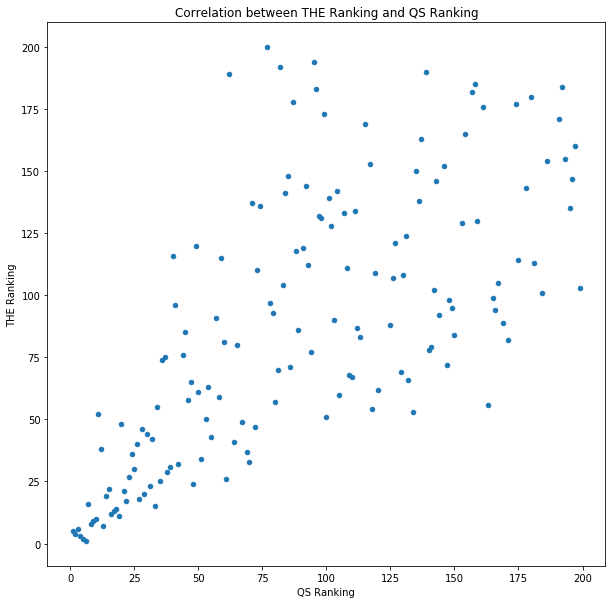

In [33]:
Merged_data.plot.scatter(x='QS_Rank_unique', y='THE_Rank_unique', title = 'Correlation between THE Ranking and QS Ranking', figsize = (10,10))
import scipy
r_s =  scipy.stats.spearmanr(Merged_data.QS_Rank_unique, Merged_data.THE_Rank_unique)[0]
plt.ylabel('THE Ranking')
plt.xlabel('QS Ranking')
print('The Spearman rank coefficient between the two rankings is:') 
print(r_s)

The correlation between the to rankings is quite high. This is to be expected as both rankings place their main emphasis on reputation, citations and research. Differences are expected to arise from the different weightings of faculty/student ratios and international student ratios between the rankings.

The scatter plot shows that the relationship between the rankings is roughly the same at different scales (Top 25, Top 50, Top 100, Top 200)

#### Comparing ranking with staff/student ratio

We do not expect significant correlations as factors like research and reputation are given much more weight in both of the rankings. We expect slightly stronger correlation for the QS-ranking, compared tot he THE ranking, since QS- directly integrates this ratio with a weight of 20 %.

Indeed the correlation for the QS-ranking is stronger than for the THE ranking. But it is itself only moderate. 

The Spearman rank coefficient between the QS-rankings and the student/staff ratio is:
0.425171089441


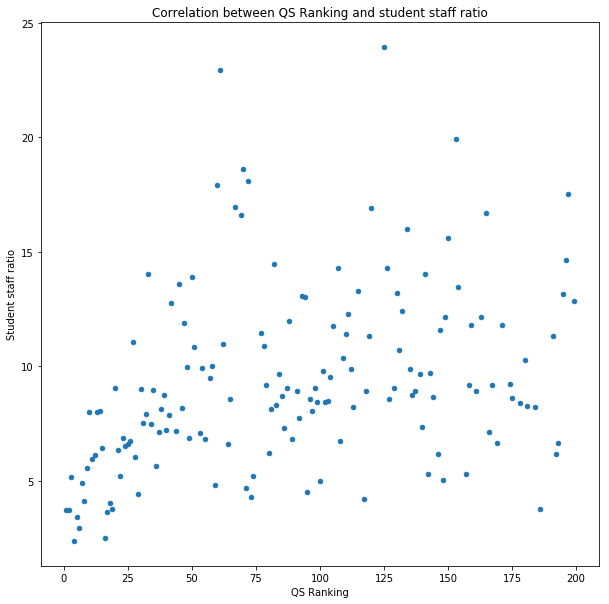

In [34]:
Merged_data.plot.scatter(x='QS_Rank_unique', y='student_staff_ratio_QS',title = 'Correlation between QS Ranking and student staff ratio', figsize = (10,10))
plt.ylabel('Student staff ratio')
plt.xlabel('QS Ranking')
r_s =  scipy.stats.spearmanr(Merged_data.QS_Rank_unique, Merged_data.student_staff_ratio_QS)[0]
print('The Spearman rank coefficient between the QS-rankings and the student/staff ratio is:') 
print(r_s)

In [35]:
#Merged_data.plot.scatter(x='THE_Rank_unique', y='student_staff_ratio_THE', title = ('Correlation between THE Ranking and student staff ratio'), figsize = (10,10))
#plt.ylabel('Student staff ratio')
#plt.xlabel('THE Ranking')
r_s =  scipy.stats.spearmanr(Merged_data.THE_Rank_unique, Merged_data.student_staff_ratio_THE)[0]
print('The Spearman rank coefficient between THE-rankings and the student/staff ratio is:') 
print(r_s)

The Spearman rank coefficient between THE-rankings and the student/staff ratio is:
0.163668449457


#### Comparing ranking with international student ratio

Since this ratio makes little direct contribution to either ranking one does not expect any significant correclation.

In [36]:
#Merged_data.plot.scatter(x='QS_Rank_unique', y='pc_intl_students_QS', title = ('Correlation between QS Ranking and percentage of international students'), figsize = (10,10))

#plt.ylabel('Percentage of international students')
#plt.xlabel('QS Ranking')

r_s =  scipy.stats.spearmanr(Merged_data.QS_Rank_unique, Merged_data.pc_intl_students_QS)[0]
print('The Spearman rank coefficient between QS-ranking and the international student ratio is:') 
print(r_s)

The Spearman rank coefficient between QS-ranking and the international student ratio is:
-0.338717579934


In [37]:
#Merged_data.plot.scatter(x='THE_Rank_unique', y='pc_intl_students_THE', title = ('Correlation between THE Ranking and percentage of international students'), figsize = (10,10))

#plt.ylabel('Percentage of international students')
#plt.xlabel('THE Ranking')

r_s =  scipy.stats.spearmanr(Merged_data.THE_Rank_unique, Merged_data.pc_intl_students_THE)[0]
print('The Spearman rank coefficient between THE-ranking and the international student ratio :') 
print(r_s)

The Spearman rank coefficient between THE-ranking and the international student ratio :
-0.179201246119


#### Comparing student/staff ratios and international student ratios between rankings

We observed earlier that the Student/Staff ratios for the two rankings could differ substanitally. Our suggestion was that Faculty in QS and Staff in THE are measured differently (for example staff could include teaching or lab assistants).

The plot below confirms this. The ratio for THE data is typically higher.

As expected, the ratios for the international students agree much better. Though there are also several universities where this data appears to be reported differently for QS and THE.

The Spearman rank coefficient between the two rankings is:
0.687298428105


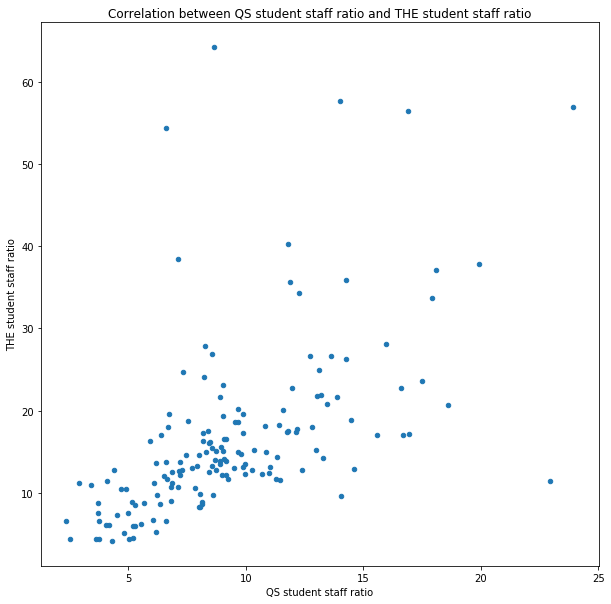

In [38]:
Merged_data.plot.scatter(x='student_staff_ratio_QS', y='student_staff_ratio_THE', title = ('Correlation between QS student staff ratio and THE student staff ratio'), figsize = (10,10))
plt.ylabel('THE student staff ratio')
plt.xlabel('QS student staff ratio')
r_s =  scipy.stats.spearmanr(Merged_data.student_staff_ratio_QS, Merged_data.student_staff_ratio_THE)[0]
print('The Spearman rank coefficient between the two rankings is:') 
print(r_s)

The Spearman rank coefficient between the two rankings is:
0.939923267074


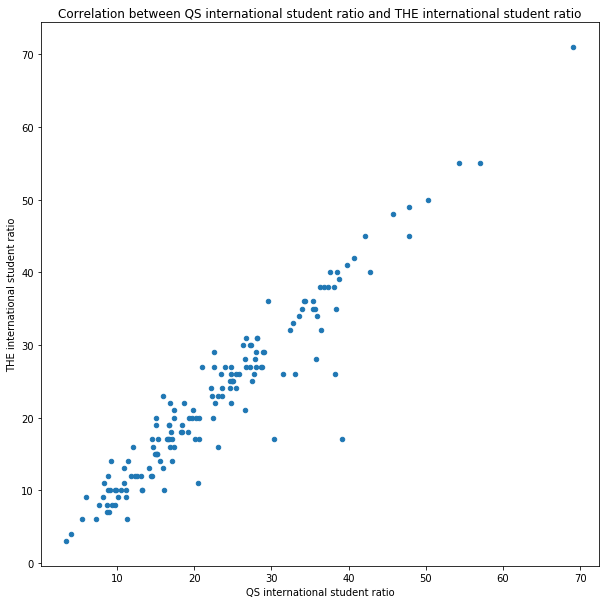

In [39]:
Merged_data.plot.scatter(x='pc_intl_students_QS', y='pc_intl_students_THE', title = ('Correlation between QS international student ratio and THE international student ratio'), figsize = (10,10))
plt.ylabel('THE international student ratio')
plt.xlabel('QS international student ratio')
r_s =  scipy.stats.spearmanr(Merged_data.pc_intl_students_QS, Merged_data.pc_intl_students_THE)[0]
print('The Spearman rank coefficient between the two rankings is:') 
print(r_s)

#### Boxplots for regional data

International student ratios by region for QS and THE

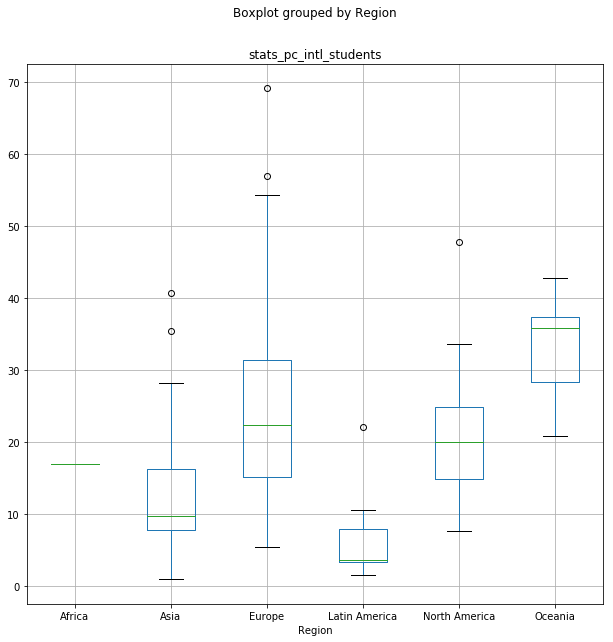

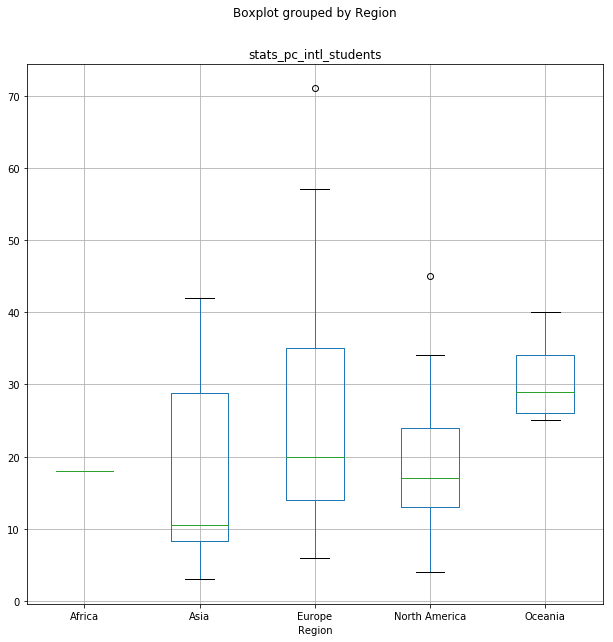

In [40]:
QS_data.boxplot(column='stats_pc_intl_students',by='Region', figsize=(10,10))
THE_data.boxplot(column='stats_pc_intl_students',by='Region', figsize=(10,10))

Student/staff ratios by region for QS and THE

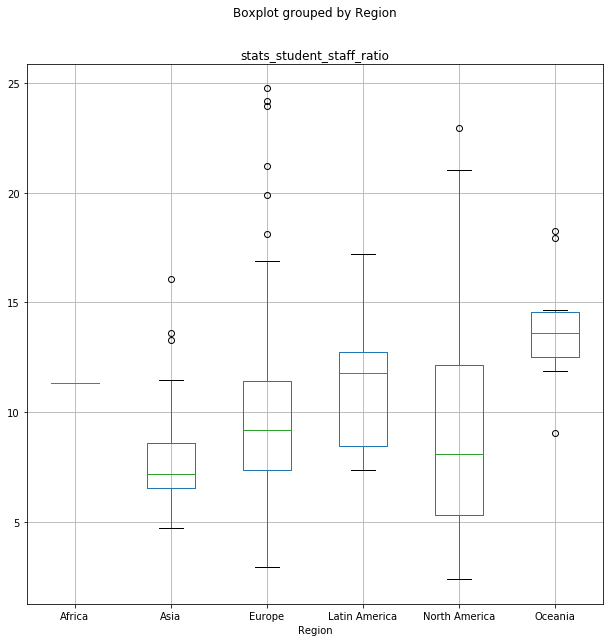

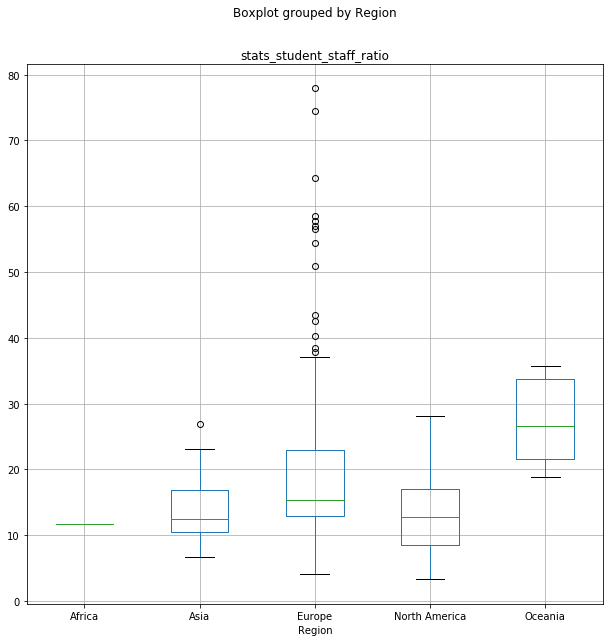

In [41]:
QS_data.boxplot(column='stats_student_staff_ratio',by='Region', figsize=(10,10))
THE_data.boxplot(column='stats_student_staff_ratio',by='Region', figsize=(10,10))

We observe that Oceania performs well in all 4 comparisons and results are placed much tigher together within Oceania. On average it outperforms the other regions. As commented earlier this has to do with the small number of universities counted in Oceania vs the large number in Europe and North America. Generally the storngest performers from Europe and North America (top end outliers) match or beat Oceania.

We were considering a direct comparison of the Top 10 universities for Oceania, Europe, North America and Asia for these metrics. However we did not have the time to pursue this analysis any further.

#### Analysing international staff numbers and rankings

We plot rankings vs international faculty size and against international staff ratio.

We find a moderate correlation between the QS_ranking and number of international faculty, whereas the correlation with the international staff ratio is only weak.

The Spearman rank coefficient between the QS_ranking and the number of international staff is:
-0.501346601277


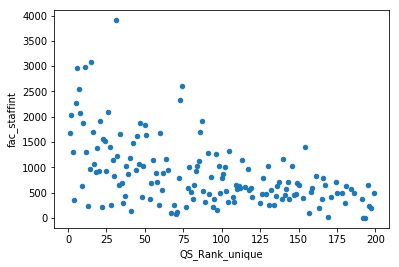

In [42]:
Merged_data.plot.scatter(x='QS_Rank_unique', y='fac_staffint')
r_s1 =  scipy.stats.spearmanr(Merged_data.QS_Rank_unique, Merged_data.fac_staffint)[0]
print('The Spearman rank coefficient between the QS_ranking and the number of international staff is:') 
print(r_s1)

In [43]:
#Merged_data.plot.scatter(x='QS_Rank_unique', y='fac_international_ratio')
r_s2 =  scipy.stats.spearmanr(Merged_data.QS_Rank_unique, Merged_data.fac_international_ratio)[0]
print('The Spearman rank coefficient between the QS_ranking and the ratio of international staff is:') 
print(r_s2)

The Spearman rank coefficient between the QS_ranking and the ratio of international staff is:
-0.345491615432


## Comments on results
According to QS World University ranking webpage (link: https://www.topuniversities.com/qs-world-university-rankings/methodology) they weight the diffrent parameters according to the below list:
1. Academic Reputation - 40 %
2. Employer Reputation - 10 %
3. Faculty/Student Ratio - 20 %
4. Citations per faculty - 20 %
5. International Faculty Ratio - 5 %
6. International Student Ratio - 5 %


THE ranking Criteria and weighting (According to wikipedia: https://en.wikipedia.org/wiki/Times_Higher_Education_World_University_Rankings#Criteria_and_weighting) :
1. Industry Income and innovation - 2.5 %
2. Ratio of international to domestic staff - 3 %
2. Ratio of international to domestic students - 2 %
3. Reputational survey (teaching) - 15 %
4. Teaching – the learning environment - 15 %
5. Research – volume, income and reputation - 30 % where Reputational survey (research) is 19.5 %
6. Citations – research influence - 32.5 % 

Both rankings values reputation and citations more, QS 70% and THE 67 %. Since we do not have any data over citations or reputation we can't confirm this. But we can confirm that student staff ratio and percentage of internationall student is less important in the ranking. 

The correlation between ranking and student staff ratio is 0.425171089441 for QS and -0.179201246119 for THE. This weak correlation is supported by the above weighting and that QS gives a higher weight to student staff ratio (20 %) compared to THE.

The correlation between ranking and percentage of international students is also weak, -0.338717579934 for QS and -0.179201246119 for THE. Which is also supported the weighting above.

For the QS ranking there is a stronger correlation between the number of international staff and ranking. The Spearman rank coefficient between the QS_ranking and the number of international staff is -0.501346601277. This can probably be explained that if a university have a good reputation it attracts more international researchers. 



## Task 5, the best university raking taking in consideration both rankings.

Both QS and THE are strongly focused on research and reputation in their rankings. We observe that we have no direct access to the reputation surveys or the citation data used by either ranking in order to judge their impact.

Instead we seek a ranking that is more focused on student related data. For our ranking we will equally weight: 1) average rank between QS and THE (hence indirectly incorporating reputation and research); 2) student/staff ratio and 3) international student ratio. Each university can get 155-0 points for each category and then we rank universities according to the total scores. 


In [44]:

#Average ranking
#Get the respective ranking data
QS_rank1 = Merged_data.QS_Rank
THE_rank1 =  Merged_data.THE_Rank
#Take away = signs in the series and make the values nmeric
QS_rank1 = QS_rank1.str.replace(r'=', '')
THE_rank1 = THE_rank1.str.replace(r'=', '')
THE_rank1 = pd.to_numeric(THE_rank1)
QS_rank1 = pd.to_numeric(QS_rank1)
#Add the to series and sort the new series
average = (THE_rank1 + QS_rank1)
average = average.sort_values()


i = 155
j = 0
average1 = average.reset_index(drop=True)
#Give the diffrent univesities points from 155-0 depending on overall ranking.
for d in average:
    average1[j] = i
    i = i-1
    j = j +1
#Index according to the average rank
average1.index = average.index
average1.sort_index(inplace=True)

# Student staff ratio, same method as for Average ranking

QS_staff = Merged_data.student_staff_ratio_QS
THE_staff =  Merged_data.student_staff_ratio_THE
THE_staff = pd.to_numeric(THE_staff)
QS_staff = pd.to_numeric(QS_staff)
average_staff = (THE_staff + QS_staff)
average_staff = average_staff.sort_values()
average_staff
i = 155
j = 0
average1_staff = average_staff.reset_index(drop=True)
for d in average_staff:
    average1_staff[j] = i
    i = i-1
    j = j +1
average1_staff.index = average_staff.index
average1_staff.sort_index(inplace=True)

# International student ratio, same method as for Average ranking
QS_int = Merged_data.pc_intl_students_QS
THE_int =  Merged_data.pc_intl_students_THE
THE_int = pd.to_numeric(THE_int)
QS_int = pd.to_numeric(QS_int)
average_int = (THE_int + QS_int)
average_int = average_int.sort_values(ascending=False)
i = 155
j = 0
average1_int = average_int.reset_index(drop=True)
for d in average_int:
    average1_int[j] = i
    i = i-1
    j = j +1
average1_int.index = average_int.index
average1_int.sort_index(inplace=True)

#Sum up the points
average_total = average1_int + average1_staff +average1
average_total = average_total.sort_values(ascending=False)
#Get name of the diffrent index in series
name = Merged_data.Name_QS 
name.index = average_total.index
name = name.sort_index() 
name = name.to_frame('University')
name['Rank'] = pd.Series(range(1,157))
name

,University,Rank
0,California Institute of Technology (Caltech),1
1,Yale University,2
2,Johns Hopkins University,3
3,UCL (University College London),4
4,University of Cambridge,5
5,Stanford University,6
6,Harvard University,7
7,Massachusetts Institute of Technology (MIT),8
8,Princeton University,9
9,Cornell University,10
